In [ ]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
t_train = pd.read_csv("train_label.csv")
t_test = pd.read_csv("test_label.csv")
t_validation = pd.read_csv("val_label.csv")
t_train = t_train.values
t_test = t_test.values
t_validation = t_validation.values

In [ ]:
x_train = pd.read_csv("train_data.csv")
x_test = pd.read_csv("test_data.csv")
x_validation = pd.read_csv("val_data.csv")
x_train = x_train.values
x_test = x_test.values
x_validation = x_validation.values

In [ ]:
def generate_polynomial_basis(M):
    basis_functions = []
    for degree in range(M + 1):
        for exponents in itertools.product(range(degree + 1), repeat=len(x_train[0])):
            if sum(exponents) == degree:
                basis_functions.append(exponents)

    return basis_functions

In [ ]:
def generate_design_matrix(X, basis_functions):
    n_samples, n_variables = X.shape

    # Initialize the design matrix
    design_matrix = np.ones((n_samples, len(basis_functions)))

    # Populate the design matrix
    for i, exponents in enumerate(basis_functions):
        term = np.prod([X[:, j]**exponents[j] for j in range(n_variables)], axis=0)
        design_matrix[:, i] = term

    return design_matrix

In [ ]:
def estimate_parameters(Phi, t, λ):
    d = Phi.shape[1]
    I = np.eye(d)
    # Estimate the coefficients using: (Phi.T * Phi)^-1 * Phi.T * y
    x = np.linalg.inv((Phi.T @ Phi) + λ*I)  # Inverse of Phi^T * X
    y = Phi.T @ t  # Phi^T * t
    w = x @ y  # (Phi^T * Phi)^-1 * Phi^T * t

    return w

In [ ]:
t_train.shape

(110, 1)

In [ ]:
def fit(x_train, t_train, M, λ=0):
  basis_functions = generate_polynomial_basis(M)
  Phi = generate_design_matrix(x_train, basis_functions)
  w = estimate_parameters(Phi, t_train, λ)
  return Phi, w

In [ ]:
def predict(X, w, M):
    X = np.asarray(X)
    basis_functions = generate_polynomial_basis(M)
    X_design = generate_design_matrix(X, basis_functions)
    y_pred = X_design @ w
    return y_pred

In [ ]:
def Erms(y, t):
    return np.sqrt(sum((y - t)**2) / len(t)).item()

In [ ]:
from sklearn.metrics import r2_score

def calculate_accuracy(y_true, y_pred):
    return r2_score(y_true, y_pred)

In [ ]:
def plot_predict_actual(y, t, M, λ=0):
  # Plotting actual vs predicted values
  plt.figure(figsize=(5, 3))
  plt.scatter(t, y, color='blue', label='Predicted vs Actual')

  # Plotting a diagonal line for reference (perfect prediction line)
  plt.plot([min(t), max(t)], [min(t), max(t)], color='red', linestyle='--', label='Perfect Prediction')

  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title(f'Predicted vs Actual Values for Degree={M}, λ={λ}')
  plt.legend()
  plt.show()

In [ ]:
def plot_curve(w, M):
  x_plot = np.linspace(min(np.concatenate((x_train, x_validation, x_test))),
                      max(np.concatenate((x_train, x_validation, x_test))), 100)
  y_plot = predict(x_plot, w, M)

  # Plotting actual vs predicted values
  plt.figure(figsize=(10, 6))
  plt.scatter(x_train, t_train, color='red', label='Train Data')
  plt.scatter(x_test, t_test, color='blue', label='Test Data')
  plt.scatter(x_validation, t_validation, color='black', label='Validation Data')
  plt.plot(x_plot, y_plot, color='green', label='Curvfitting Without Regularizer')

  # plt.xlim(min(x_train)-0.2, max(x_train)+0.2)  # x-axis limits from 0 to 6
  # plt.ylim(min(t_train)-1, max(t_train)+1)  # y-axis limits from 0 to 30

  plt.xlabel('X Data')
  plt.ylabel('Y Output')
  plt.title(f'Polynomial Curve Fitting for Dataset 1 Degree={M}')
  plt.legend()
  plt.show()


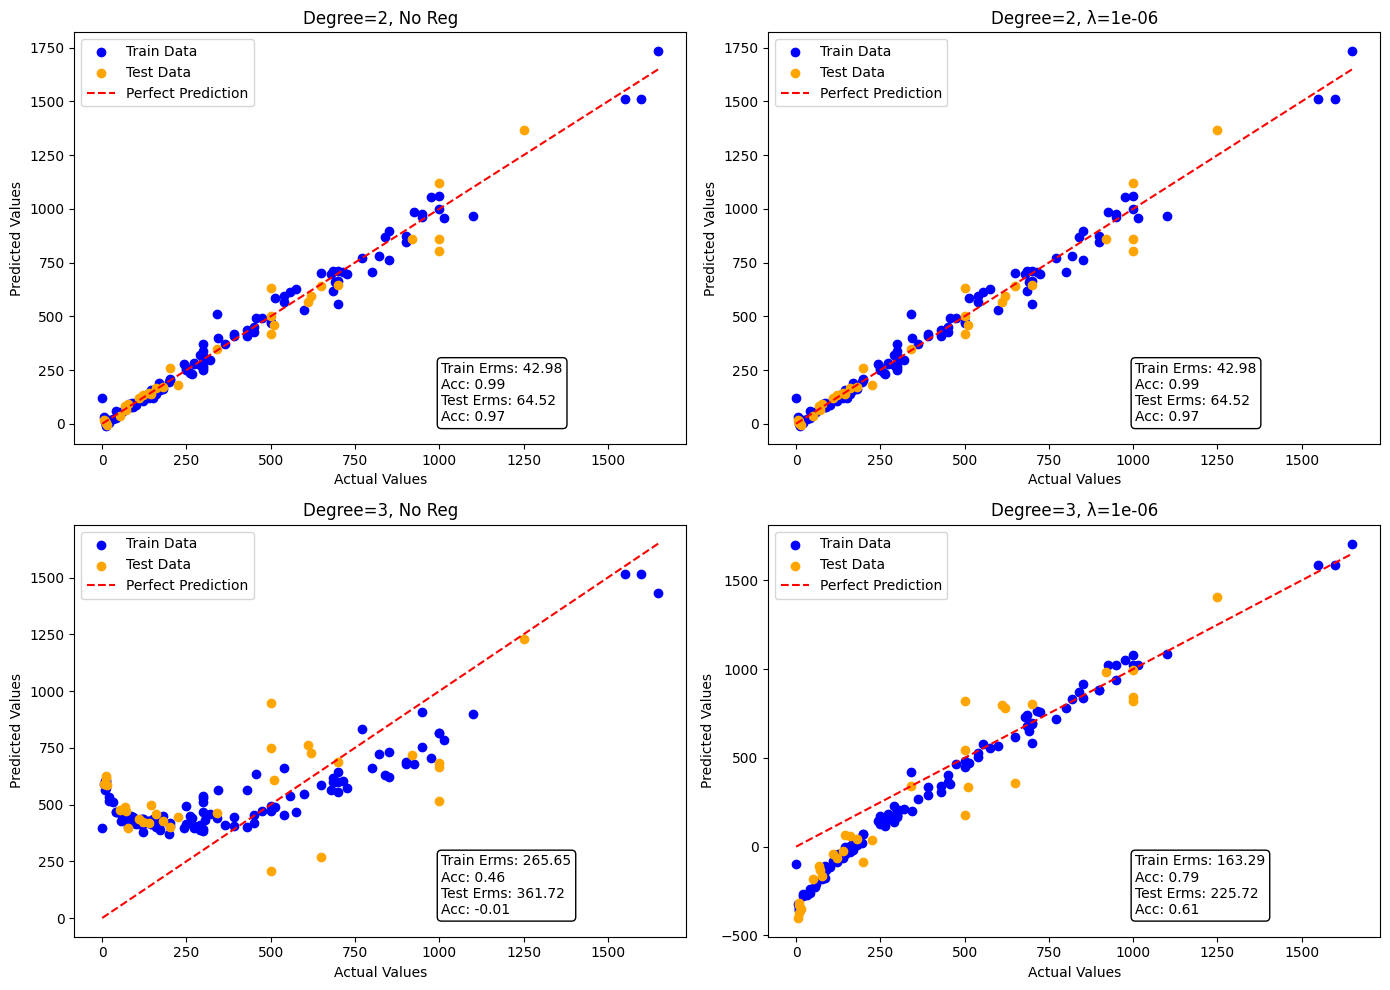

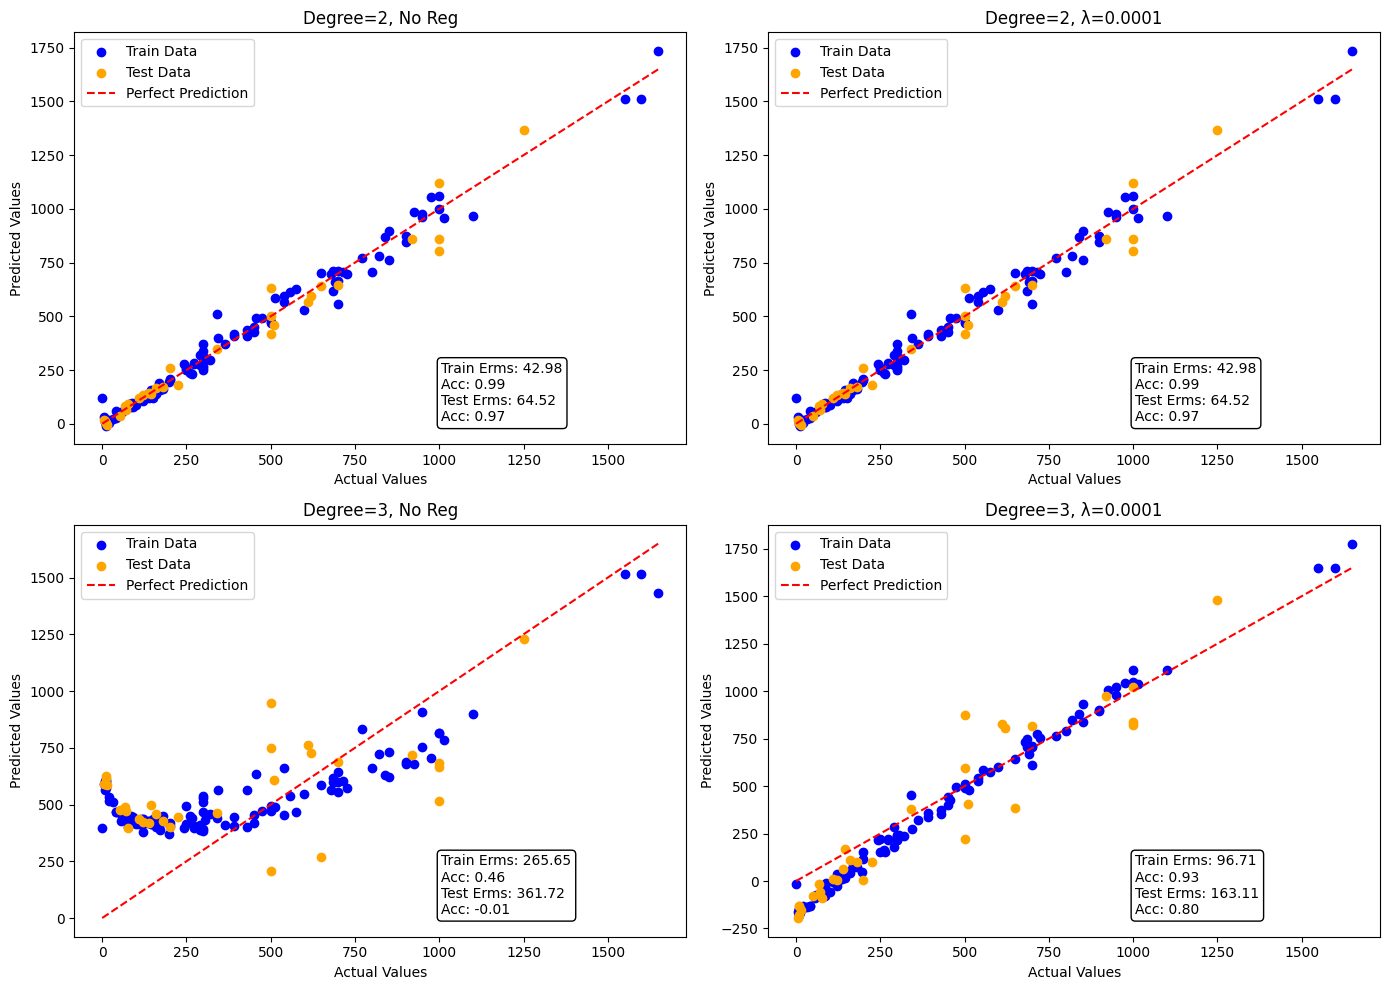

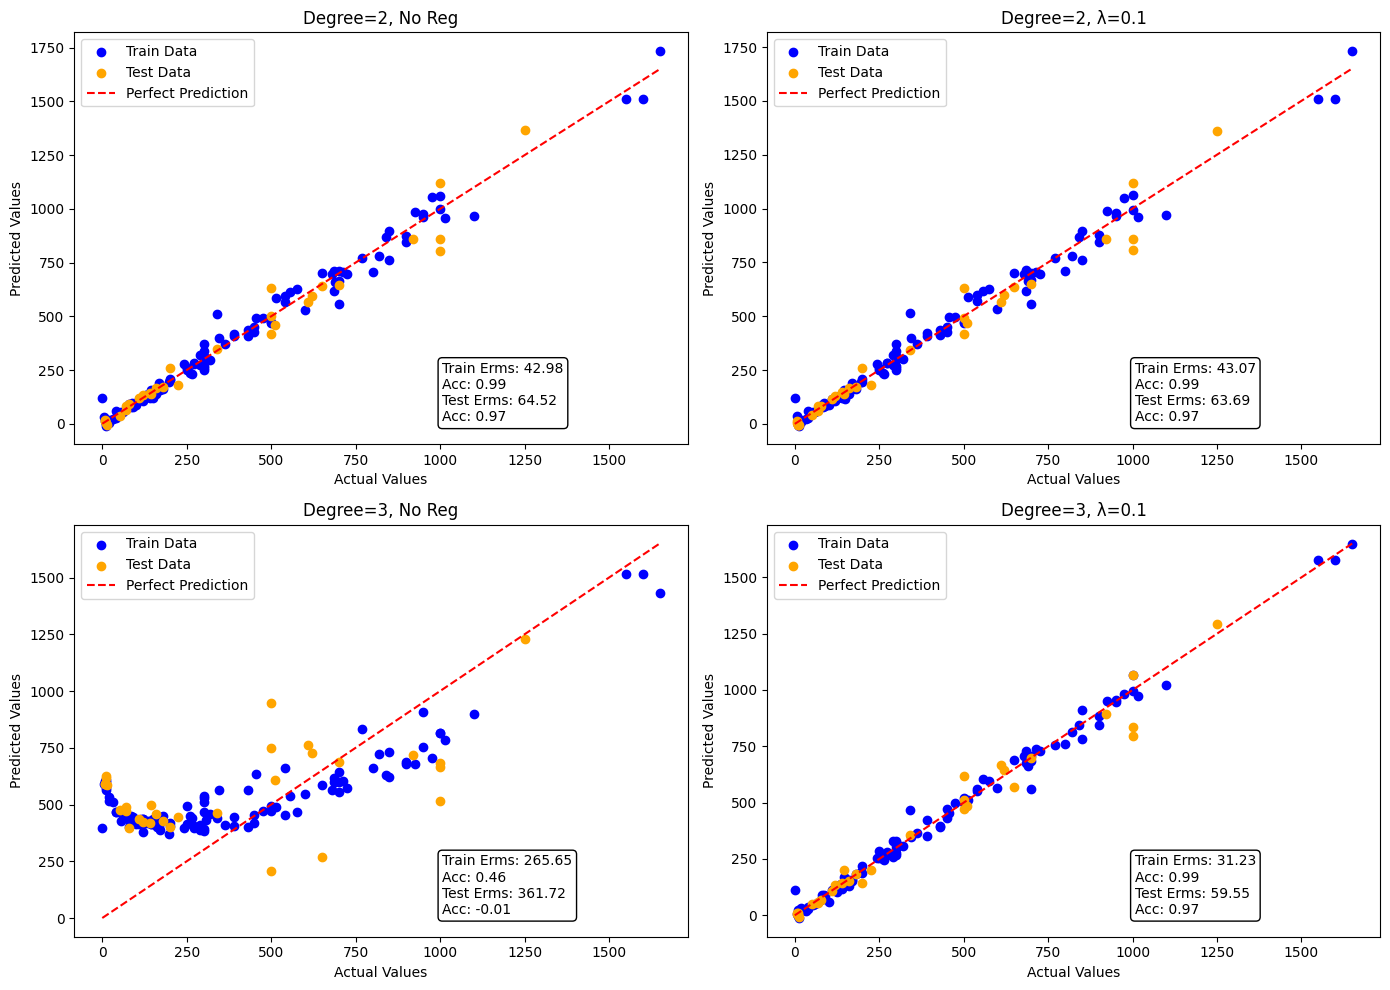

In [ ]:
def plot_predict_actual_side_by_side(M_values, λ=0):
    n_cols = 2  # One column for "No Regularization" and one for "With Regularization"
    n_rows = len(M_values)  # One row per M value

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))

    for i, M in enumerate(M_values):
        # Train the model without regularization
        Phi, w = fit(x_train, t_train, M)
        y_train = predict(x_train, w, M)
        y_test = predict(x_test, w, M)

        # Calculate Erms and accuracy for train and test data without regularization
        Erms_train = Erms(y_train, t_train)
        accuracy_train = calculate_accuracy(t_train, y_train)
        Erms_test = Erms(y_test, t_test)
        accuracy_test = calculate_accuracy(t_test, y_test)

        # Train the model with regularization
        Phi_with_Reg, w_with_reg = fit(x_train, t_train, M, λ)
        y_train_with_reg = predict(x_train, w_with_reg, M)
        y_test_with_reg = predict(x_test, w_with_reg, M)

        # Calculate Erms and accuracy for train and test data with regularization
        Erms_train_with_reg = Erms(y_train_with_reg, t_train)
        accuracy_train_with_reg = calculate_accuracy(t_train, y_train_with_reg)
        Erms_test_with_reg = Erms(y_test_with_reg, t_test)
        accuracy_test_with_reg = calculate_accuracy(t_test, y_test_with_reg)

        # Plotting the predicted vs actual values without regularization
        axes[i, 0].scatter(t_train, y_train, color='blue', label='Train Data')
        axes[i, 0].scatter(t_test, y_test, color='orange', label='Test Data')
        axes[i, 0].plot([min(t_train), max(t_train)], [min(t_train), max(t_train)], color='red', linestyle='--', label='Perfect Prediction')
        axes[i, 0].set_xlabel('Actual Values')
        axes[i, 0].set_ylabel('Predicted Values')
        axes[i, 0].set_title(f'Degree={M}, No Reg')
        axes[i, 0].legend()

        # Add text annotation for Erms and accuracy without regularization
        text_str_no_reg = (
            f"Train Erms: {Erms_train:.2f}\nAcc: {accuracy_train:.2f}\n"
            f"Test Erms: {Erms_test:.2f}\nAcc: {accuracy_test:.2f}"
        )
        axes[i, 0].text(0.6, 0.2, text_str_no_reg, transform=axes[i, 0].transAxes, fontsize=10,
                        verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

        # Plotting the predicted vs actual values with regularization
        axes[i, 1].scatter(t_train, y_train_with_reg, color='blue', label='Train Data')
        axes[i, 1].scatter(t_test, y_test_with_reg, color='orange', label='Test Data')
        axes[i, 1].plot([min(t_train), max(t_train)], [min(t_train), max(t_train)], color='red', linestyle='--', label='Perfect Prediction')
        axes[i, 1].set_xlabel('Actual Values')
        axes[i, 1].set_ylabel('Predicted Values')
        axes[i, 1].set_title(f'Degree={M}, λ={λ}')
        axes[i, 1].legend()

        # Add text annotation for Erms and accuracy with regularization
        text_str_with_reg = (
            f"Train Erms: {Erms_train_with_reg:.2f}\nAcc: {accuracy_train_with_reg:.2f}\n"
            f"Test Erms: {Erms_test_with_reg:.2f}\nAcc: {accuracy_test_with_reg:.2f}"
        )
        axes[i, 1].text(0.6, 0.2, text_str_with_reg, transform=axes[i, 1].transAxes, fontsize=10,
                        verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

    plt.tight_layout()
    plt.show()

# Define the range of polynomial degrees (M) and regularization parameter (lambda)
M_values = [2, 3]
λ = 0.000001

# Plot predicted vs actual values for different M values with and without regularization
plot_predict_actual_side_by_side(M_values, λ)

λ = 0.0001

# Plot predicted vs actual values for different M values with and without regularization
plot_predict_actual_side_by_side(M_values, λ)

λ = 0.1

# Plot predicted vs actual values for different M values with and without regularization
plot_predict_actual_side_by_side(M_values, λ)


Train Data Erms: 42.98034021368713
Train Data Accuracy: 0.985780722139992
Test Data Erms: 64.51662094376627
Test Data Accuracy: 0.9679452982279279
Validation Data Erms: 65.33012319414567
Validation Data Accuracy: 0.9637319097114332
Train Data:


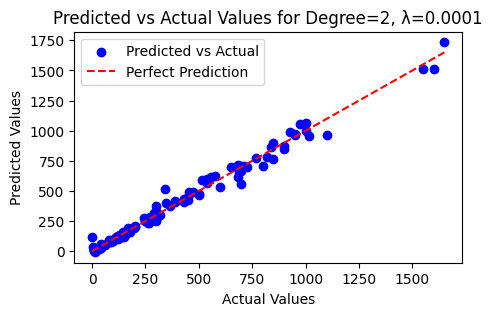

Test Data:


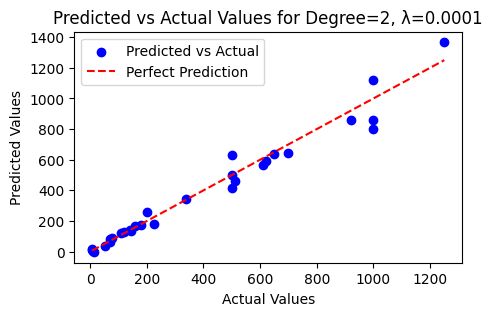

Validation Data:


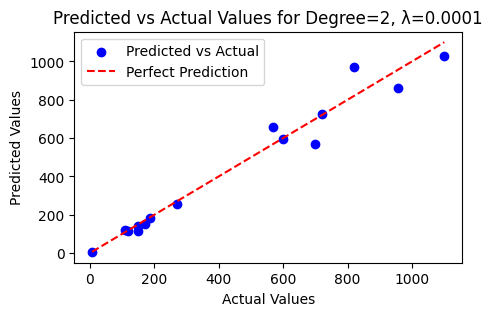

In [ ]:
#Hyperparameter
#Highest Degree
M=2
λ=0.0001

#Train The Model
Phi, w = fit(x_train, t_train, M, λ)


#Model Performance analysis on Train data
y_train = predict(x_train, w, M)
accuracy_train=calculate_accuracy(t_train, y_train)
Erms_train = Erms(y_train, t_train)

print(f"Train Data Erms: {Erms_train}")
print(f"Train Data Accuracy: {accuracy_train}")


#Model Performance analysis on Test data
y_test = predict(x_test, w, M)
accuracy_test=calculate_accuracy(t_test, y_test)
Erms_test = Erms(y_test, t_test)

print(f"Test Data Erms: {Erms_test}")
print(f"Test Data Accuracy: {accuracy_test}")


#Model Performance analysis on Validation data
y_validation = predict(x_validation, w, M)
accuracy_validation=calculate_accuracy(t_validation, y_validation)
Erms_validation = Erms(y_validation, t_validation)

print(f"Validation Data Erms: {Erms_validation}")
print(f"Validation Data Accuracy: {accuracy_validation}")

#Visualization of Model

print("Train Data:")
plot_predict_actual(y_train, t_train, M, λ)

print("Test Data:")
plot_predict_actual(y_test, t_test, M, λ)

print("Validation Data:")
plot_predict_actual(y_validation, t_validation, M, λ)